In [65]:
import copy
import os
import argparse
import torch
import numpy as np
import random

%load_ext autoreload
%autoreload 2
from erasure.utils.config.local_ctx import Local
from erasure.utils.config.global_ctx import Global 
from erasure.core.factory_base import ConfigurableFactory
from erasure.data.datasets.DatasetManager import DatasetManager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
config_file = os.path.join("configs", "playmydata.jsonc")
#config_file = os.path.join("configs", "example.jsonc")


global_ctx = Global(config_file)
global_ctx.factory = ConfigurableFactory(global_ctx)

#Create Dataset
data_manager = global_ctx.factory.get_object( Local( global_ctx.config.data ))
global_ctx.dataset = data_manager

2025-01-27 15:13:11,-1474563112 | INFO | 2410926 - Creating Global Context for: configs/playmydata.jsonc
2025-01-27 15:13:11,-1474563107 | INFO | 2410926 - Setting seeds to: 1046534644
2025-01-27 15:13:11,-1474563101 | INFO | 2410926 - Caching System: True.
2025-01-27 15:13:11,-1474563100 | INFO | 2410926 - Created Configurable: erasure.data.data_sources.TorchVisionCustomSource.TorchVisionCustomSource
2025-01-27 15:13:11,-1474563100 | INFO | 2410926 - {'class': 'erasure.data.data_sources.TorchVisionCustomSource.TorchVisionCustomSource', 'parameters': {'path': 'resources/data/playmydata', 'file_name': 'playmydata.csv', 'transform': ['ToTensor'], 'label': 'rating', 'RGB': True}}


/NFSHOME/adangelo/ERASURE/erasure/data/data_sources/TorchVisionCustomSource.py:36: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_csv = pd.read_csv(os.path.join(self.path, self.file_name), index_col=0)


2025-01-27 15:13:30,-1474544633 | INFO | 2410926 -                                                     path      id  \
0      resources/data/playmydata/screenshots/screensh...  100023   
1      resources/data/playmydata/screenshots/screensh...  100023   
2      resources/data/playmydata/screenshots/screensh...  100023   
3      resources/data/playmydata/screenshots/screensh...    1000   
4      resources/data/playmydata/screenshots/screensh...    1000   
...                                                  ...     ...   
89903  resources/data/playmydata/screenshots/screensh...       9   
89904  resources/data/playmydata/screenshots/screensh...       9   
89905  resources/data/playmydata/screenshots/screensh...       9   
89906  resources/data/playmydata/screenshots/screensh...       9   
89907  resources/data/playmydata/screenshots/screensh...       9   

                     genres                     name  \
0                   [9, 33]                   Q*bert   
1                   

In [67]:
data_manager.n_classes

90

In [68]:
all_loader, _ = data_manager.get_loader_for('all_shuffled')

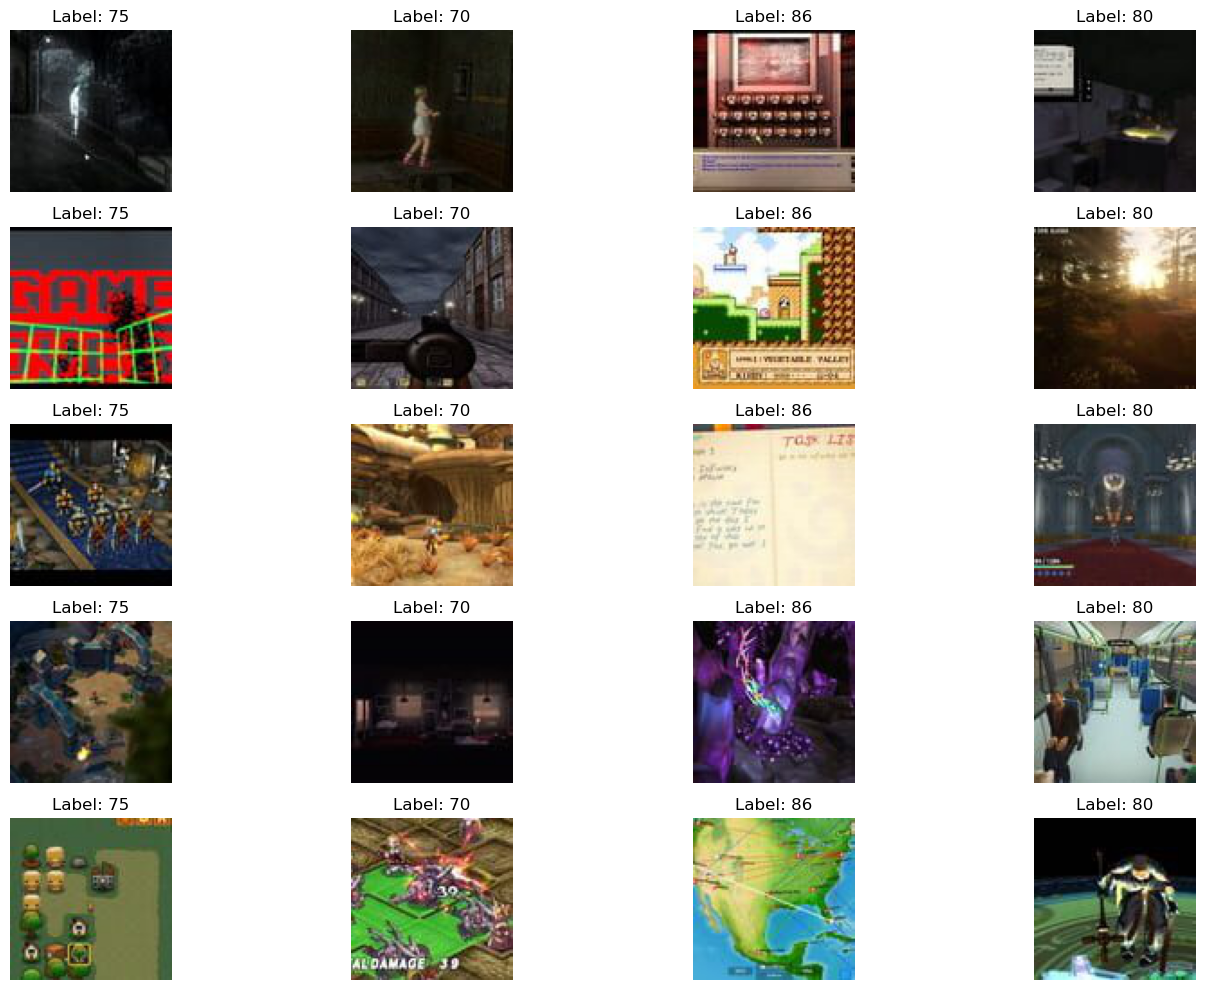

In [73]:
import matplotlib.pyplot as plt

# Parameters
num_images_to_display = 20
images_per_row = 4  # Number of images per row for a grid layout
images_displayed = 0

# Collect and display images
plt.figure(figsize=(15, 10))  # Set the figure size

for X, y in all_loader:
    # Convert the batch to NumPy
    np_images = X.permute(0, 2, 3, 1).numpy()  # Change shape to (N, H, W, C)
    
    # Loop through images in the batch
    for img, label in zip(np_images, y):
        images_displayed += 1
        
        # Add subplot for each image
        plt.subplot(num_images_to_display // images_per_row, images_per_row, images_displayed)
        plt.imshow(img)  # Assuming the range is already suitable for visualization
        plt.title(f"Label: {label[0].item()}")  # Display label
        plt.axis("off")
        
        if images_displayed == num_images_to_display:
            break  # Stop after displaying the required number of images
    if images_displayed == num_images_to_display:
        break

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig('2820_new_new.png')
plt.show()


In [10]:
loader, _ = data_manager.get_loader_for('train')

2025-01-26 12:43:01,-1569973494 | INFO | 1836067 - TRAINING WITH 146293 samples


In [13]:

from erasure.utils.config.global_ctx import bcolors


#Create Predictor
current = Local(global_ctx.config.predictor)
current.dataset = data_manager
predictor = global_ctx.factory.get_object(current)
global_ctx.predictor = predictor
global_ctx.logger.info('Global Predictor: ' + str(predictor))

#Create unlearners 
unlearners = []
unlearners_cfg = global_ctx.config.unlearners
for un in unlearners_cfg:
    current = Local(un)
    current.dataset = data_manager
    current.predictor = copy.deepcopy(predictor)
    unlearners.append( global_ctx.factory.get_object(current) )


#Evaluator
current = Local(global_ctx.config.evaluator)
current.unlearners = unlearners
evaluator = global_ctx.factory.get_object(current)

# Evaluations
for unlearner in unlearners:
    global_ctx.logger.info(f'''{bcolors.OKGREEN}####\t\t Evaluating: {unlearner.__class__.__name__} \t\t####{bcolors.ENDC}''')
    evaluator.evaluate(unlearner,predictor)

 

2025-01-25 11:32:03,-1660631110 | INFO | 1212714 - Instantiating: erasure.model.classifiers.resnet18_for_celeba.CelebAResNet18


/NFSHOME/adangelo/miniconda3/envs/representer/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/NFSHOME/adangelo/miniconda3/envs/representer/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2025-01-25 11:32:04,-1660630687 | INFO | 1212714 - Instantiating: torch.optim.Adam
2025-01-25 11:32:04,-1660630685 | INFO | 1212714 - Instantiating: torch.nn.CrossEntropyLoss
2025-01-25 11:32:04,-1660630682 | INFO | 1212714 - TRAINING WITH 14628 samples


KeyboardInterrupt: 